# Task: Using neural network to predict hand-written digits

## 0. Import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F     
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

## 1. Data preparation

In [2]:
# Load MNIST datasets
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
print(f'Number of training data: {len(train_data)}')
print(f'Number of test data: {len(test_data)}')

Number of training data: 60000
Number of test data: 10000


Shape: torch.Size([1, 28, 28]) 
Label: 5


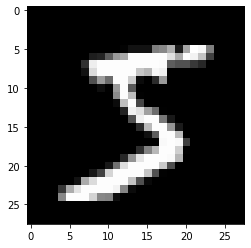

In [3]:
# Take a look at the very first data
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)
plt.imshow(image.reshape((28,28)), cmap="gray");

In [4]:
# Batch loading with DataLoader
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)  # for both validation and test

## 2. Making prediction w/ neural network

### 2.1. Define the neural network model

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.softmax(X, dim=1)

In [6]:
# Declare the model
torch.manual_seed(101)
model = NeuralNet()
model

NeuralNet(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [9]:
# Flatten the training data
images.view(100,-1).size()

torch.Size([100, 784])

### 2.2. Train the model

In [10]:
start_time = time.time()

epochs = 10
train_losses = []
valid_losses = []
train_correct = []
valid_correct = []

for i in range(epochs):
    train_corr = 0
    valid_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1)) 
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b % 200 == 0:
            print(f'epoch: {i:2}  batch: {b:4}  loss: {loss.item():10.8f}  accuracy: {train_corr.item() * 100 / (100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(train_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            valid_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    valid_losses.append(loss)
    valid_correct.append(valid_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')  

epoch:  0  batch:  200  loss: 1.59293294  accuracy:  76.940%
epoch:  0  batch:  400  loss: 1.56869948  accuracy:  83.830%
epoch:  0  batch:  600  loss: 1.55029249  accuracy:  86.507%
epoch:  1  batch:  200  loss: 1.53789258  accuracy:  92.825%
epoch:  1  batch:  400  loss: 1.48226011  accuracy:  93.267%
epoch:  1  batch:  600  loss: 1.52553630  accuracy:  93.555%
epoch:  2  batch:  200  loss: 1.54644454  accuracy:  94.580%
epoch:  2  batch:  400  loss: 1.54512751  accuracy:  94.567%
epoch:  2  batch:  600  loss: 1.50326681  accuracy:  94.743%
epoch:  3  batch:  200  loss: 1.54868150  accuracy:  95.630%
epoch:  3  batch:  400  loss: 1.47799897  accuracy:  95.465%
epoch:  3  batch:  600  loss: 1.48216176  accuracy:  95.487%
epoch:  4  batch:  200  loss: 1.48959446  accuracy:  96.150%
epoch:  4  batch:  400  loss: 1.48857331  accuracy:  96.108%
epoch:  4  batch:  600  loss: 1.49711490  accuracy:  96.087%
epoch:  5  batch:  200  loss: 1.51597142  accuracy:  96.665%
epoch:  5  batch:  400  

### Plot the loss and accuracy comparisons

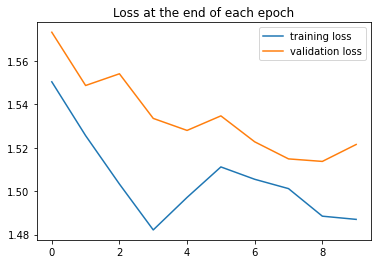

In [12]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(valid_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend()

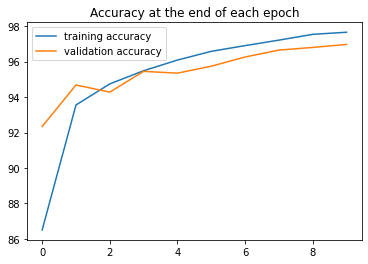

In [15]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in valid_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

### Evaluate Test Data

In [16]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9697/10000 =  96.970%
